In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def GaussianLPF(height, width, radius=10):  # 高斯低通滤波器
    # Gaussian：kern = exp(-D^2/(2*D0^2))
    u, v = np.mgrid[-1:1:2.0/height, -1:1:2.0/width]
    Dist = cv.magnitude(u, v)  # 距离
    D0 = radius / height  # 滤波器半径
    kernel = np.exp(-(Dist**2)/(2*D0**2))
    return kernel

In [3]:
# (1) 读取原始图像 (h,w)
img = cv.imread("Fig1101.png", flags=0)  # 灰度图像
imgFloat = np.float32(img[:501,:487])  # 将图像转换成 float32
# 此处截取图像尺寸为[501,487]并非必须，只是为了比较DFT最优扩充的影响
hImg, wImg = imgFloat.shape[:2]  # (510, 495)

In [4]:
# (2) 图像扩充：计算DFT最优尺寸，对图像右侧下侧补0，(hImg,wImg)->(hPad,wPad)
hPad = cv.getOptimalDFTSize(hImg)  # DFT 最优尺寸
wPad = cv.getOptimalDFTSize(wImg)
imgPadded = cv.copyMakeBorder(imgFloat,0,hPad-hImg,0,wPad-wImg,cv.BORDER_CONSTANT)

In [5]:
# (3) 快速傅里叶变换：实部为 dft[:,:,0]，虚部为 dft[:,:,0]
dftImg = cv.dft(imgPadded, flags=cv.DFT_COMPLEX_OUTPUT)  # DFT (hPad,wPad,2)

In [6]:
# (4) 中心化：将低频分量移动到中心
dftShift = np.fft.fftshift(dftImg)  # (hPad,wPad,2)

In [7]:
# (5) 构造频域滤波器传递函数，扩展为 2个通道
# filterLP = ButterworthLPF(hPad, wPad, radius=50)  # 巴特沃斯低通滤波器
filterLP = GaussianLPF(hPad, wPad, radius=50)  # 高斯低通滤波器
filterDual = cv.merge([filterLP, filterLP])  # 拼接为 2个通道：(hPad,wPad,2)

In [8]:
# (6) 频域变换：修改傅里叶变换实现频域滤波
dftFiltered = dftShift * filterDual  # 频域滤波 (hPad,wPad,2)

In [9]:
# (7) 逆中心化：将低频逆移回图像四角
iShift = np.fft.ifftshift(dftFiltered)  # (hPad,wPad,2)

In [10]:
# (8) 傅里叶逆变换，使用幅度谱恢复图像
iDft = cv.idft(iShift)  # 傅里叶逆变换 (hPad,wPad,2)
iDftMag = cv.magnitude(iDft[:,:,0], iDft[:,:,1])  # 重建图像 (hPad,wPad)

In [11]:
# (9) 截取左上角，转换为 CV_8U
clipped = iDftMag[:hImg, :wImg]  # 切片获得原始图像尺寸 (h,w)
imgLPF = np.uint8(cv.normalize(clipped, None, 0, 255, cv.NORM_MINMAX))

In [12]:
print("imgFloat:{}".format(imgFloat.shape))  # (501, 487)
print("imgPadded:{}".format(imgPadded.shape))  # (512, 500)
print("dftImp:{}".format(dftImg.shape))  # (512, 500,2)
print("filterLP:{}".format(filterLP.shape))  # (512, 500)
print("filterDual:{}".format(filterDual.shape))  # (512, 500,2)
print("dftFiltered:{}".format(dftFiltered.shape))  # (512, 500,2)
print("iShift:{}".format(iShift.shape))  # (512, 500,2)
print("iDftAmp:{}".format(iDftMag.shape))  # (512, 500)
print("imgLPF:{}".format(imgLPF.shape))  # (501, 487)

imgFloat:(501, 487)
imgPadded:(512, 500)
dftImp:(512, 500, 2)
filterLP:(512, 500)
filterDual:(512, 500, 2)
dftFiltered:(512, 500, 2)
iShift:(512, 500, 2)
iDftAmp:(512, 500)
imgLPF:(501, 487)


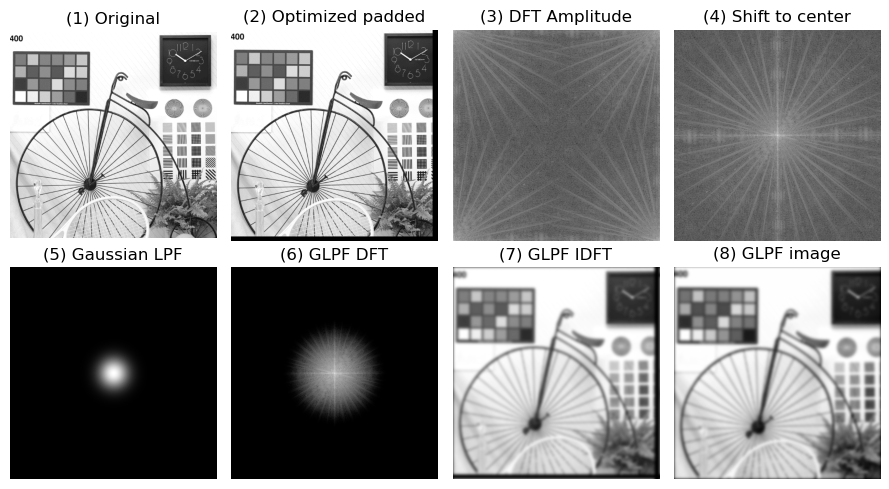

In [13]:
fig = plt.figure(figsize=(9, 5))
plt.subplot(241), plt.axis('off'), plt.title("(1) Original")
plt.imshow(img, cmap='gray')
plt.subplot(242), plt.axis('off'), plt.title("(2) Optimized padded")
plt.imshow(imgPadded, cmap='gray')
plt.subplot(243), plt.axis('off'), plt.title("(3) DFT Amplitude")
dftAmp = cv.magnitude(dftImg[:,:,0], dftImg[:,:,1])  # 幅度谱
ampLog = np.log(1.0 + dftAmp)  # 幅度谱对数变换
plt.imshow(ampLog, cmap='gray')
plt.subplot(244), plt.axis('off'), plt.title("(4) Shift to center")
shiftDftAmp = cv.magnitude(dftShift[:,:,0], dftShift[:,:,1])
shiftAmpLog = np.log(1 + shiftDftAmp)  # 中心化幅度谱对数变换
plt.imshow(shiftAmpLog, cmap='gray')
plt.subplot(245), plt.axis('off'), plt.title("(5) Gaussian LPF")
plt.imshow(filterLP, cmap='gray')
plt.subplot(246), plt.axis('off'), plt.title("(6) GLPF DFT")
LPFDftAmp = cv.magnitude(dftFiltered[:,:,0], dftFiltered[:,:,1])
LPFDftAmpLog = np.log(1.0 + LPFDftAmp)
plt.imshow(LPFDftAmpLog, cmap='gray')
plt.subplot(247), plt.title("(7) GLPF IDFT"), plt.axis('off')
plt.imshow(iDftMag, cmap='gray')
plt.subplot(248), plt.title("(8) GLPF image"), plt.axis('off')
plt.imshow(imgLPF, cmap='gray')
plt.tight_layout()
plt.show()